In [0]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import sys
from itertools import count
import torch
print("PyTorch:\t{}".format(torch.__version__))
import random
import glob
import io
import base64
from torch import nn
import math
from torch import optim

PyTorch:	1.4.0


In [0]:
def discount_rewards(rewards, gam=0.99):
    rew=[]
    for i in range(len(rewards)):
        rew.append([(gam**i) * rewards[i]])
    rew=np.array([rew])
    rew = rew[::-1].cumsum()[::-1]
    a=(rew-rew.mean())
    return(a)

In [0]:
class est_pol():
    #Neural Network
    def __init__(self, env):
        #State and Action Space
        self.n_out = env.action_space.n
        self.n_inp = env.observation_space.shape[0]
        #Pytorch Network 
        self.network = nn.Sequential(
            nn.Linear(self.n_inp,32), #Linear Layer with inputs 4 and outputs 32
            nn.ReLU(), #Passing to RELU
            nn.Linear(32, self.n_out), #Linear Layer layer with inputs 32 and outputs 2
            nn.Softmax(dim=-1))#Finding Softmax
    
    #Forward function
    def pred(self, state):
        pro_act = self.network(torch.FloatTensor(state))
        return pro_act

In [0]:
def rfc(env, est_pol,gamma=0.99):
    #Initialize variables
    optimizer = optim.Adam(est_pol.network.parameters(), lr=0.001)
    rew_tot = []
    action_space = np.arange(env.action_space.n)
    act_bat = []
    avv=[]
    flag=0
    rew_bat = []
    sta_bat = []
    #Run till the agent reaches the threshold reward
    for i in count(1):
        s_0 = env.reset()
        actions = []
        done = False
        states = []
        rewards = []
        asc=0
        dest=0
        while(not done):
            # Numpy array of action to be changed
            act_pro = est_pol.pred(s_0).detach().numpy()
            act = np.random.choice(action_space, p=act_pro)
            s_1, r, done, _ = env.step(act)
            rewards.append(r)
            states.append(s_0)
            s_0 = s_1
            actions.append(act)
            if(done):
                rew_bat.extend(discount_rewards(rewards, gamma))
                rew_tot.append(sum(rewards))
                sta_bat.extend(states)
                act_bat.extend(actions)
                #Initialise Gradients
                optimizer.zero_grad()
                reward_tensor = torch.FloatTensor(rew_bat)
                state_tensor = torch.FloatTensor(sta_bat)
                action_tensor = torch.LongTensor(act_bat)
                logprob = torch.log(est_pol.pred(state_tensor))
                #Reinforce ALgorithm
                selected_logprobs = reward_tensor * torch.gather(logprob, 1, action_tensor.unsqueeze(1)).squeeze()
                loss = -selected_logprobs.mean()
                loss.backward()
                optimizer.step()
                rew_bat = []
                act_bat = []
                sta_bat = []
                avg_rewards = np.mean(rew_tot[-50:])
                avv.append(avg_rewards)
                print("Episode: {}, Rewards: {}, Average/Running Rewards: {}".format(i, sum(rewards),avg_rewards))
                if(avg_rewards > env.spec.reward_threshold):
                    print("Solved! Running/Average reward is {}".format(avg_rewards))
                    flag=1

                asc += 1
        if(flag==1):
            break

    #Plotting graph
    plt.figure(1)             
    plt.plot(avv)
    plt.title('Average Reward vs Episodes')
    plt.ylabel('Avg Reward')
    plt.xlabel('Episodes')            
    
    return rew_tot

Episode: 1, Rewards: 12.0, Average/Running Rewards: 12.0
Episode: 2, Rewards: 12.0, Average/Running Rewards: 12.0
Episode: 3, Rewards: 13.0, Average/Running Rewards: 12.333333333333334
Episode: 4, Rewards: 16.0, Average/Running Rewards: 13.25
Episode: 5, Rewards: 21.0, Average/Running Rewards: 14.8
Episode: 6, Rewards: 22.0, Average/Running Rewards: 16.0
Episode: 7, Rewards: 27.0, Average/Running Rewards: 17.571428571428573
Episode: 8, Rewards: 59.0, Average/Running Rewards: 22.75
Episode: 9, Rewards: 20.0, Average/Running Rewards: 22.444444444444443
Episode: 10, Rewards: 11.0, Average/Running Rewards: 21.3
Episode: 11, Rewards: 15.0, Average/Running Rewards: 20.727272727272727
Episode: 12, Rewards: 25.0, Average/Running Rewards: 21.083333333333332
Episode: 13, Rewards: 15.0, Average/Running Rewards: 20.615384615384617
Episode: 14, Rewards: 12.0, Average/Running Rewards: 20.0
Episode: 15, Rewards: 9.0, Average/Running Rewards: 19.266666666666666
Episode: 16, Rewards: 9.0, Average/Runni

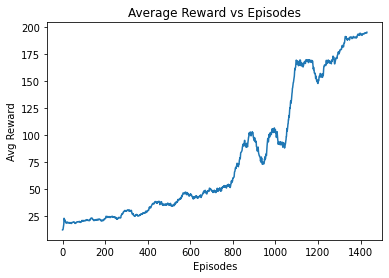

In [0]:
env = gym.make('CartPole-v0')
policy_est = est_pol(env)
gamma=0.99
total_rewards = rfc(env, policy_est,gamma)